In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import copy
import math
import scipy as sp
from scipy import optimize
from scipy.integrate import odeint
from scipy.interpolate import CubicSpline
from prettytable import PrettyTable  
import datetime as dt
import timeit
import time
import os
import sys
import time
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
sys.path.insert(0, '../../Utilities/')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
np.set_printoptions(threshold=np.inf)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data = pd.read_csv("EINN_60day.csv")

alpha1 = 1.0 #data
alpha2 = 1.0

N0 = 6629870
lb = 0
ub = 60

POINTS = 1
SEED = 123
GRID = 5

npoints = ub * POINTS
epochs = 100000

layers = [1,128,128,128,128,16]
n_mc = 10
learning_rate = 1e-6
length = int(ub-lb)


In [3]:
class ClipConstraint(tf.keras.constraints.Constraint):
    def __init__(self, min_value, max_value):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, w):
        return tf.clip_by_value(w, self.min_value, self.max_value)

class SIR:
    def __init__(self, S, V, E, I1, I2, I3, R, D, T, layers, alpha1, alpha2, dW1, dW2, dW3, dW4, dW5, dW6, dW7, dW8, n_mc):
        self.t = T
        self.S = S
        self.V = V
        self.E = E
        self.I1 = I1
        self.I2 = I2
        self.I3 = I3
        self.R = R
        self.D = D
        self.dW1 = dW1
        self.dW2 = dW2
        self.dW3 = dW3
        self.dW4 = dW4
        self.dW5 = dW5
        self.dW6 = dW6
        self.dW7 = dW7
        self.dW8 = dW8
        
        self.learning_rate = learning_rate 
        
        self.n_mc = n_mc
        self.alpha1, self.alpha2 = alpha1, alpha2


        self.layers = layers
        self.lb = T.min()
        self.ub = T.max()

        tf.set_random_seed(SEED)
        np.random.seed(SEED)
        self.birth = tf.Variable(0.000053 ,dtype=tf.float32,trainable=False)
        self.dead = tf.Variable(0.000033 ,dtype=tf.float32,trainable=False)
        
        tf.set_random_seed(SEED)
        np.random.seed(SEED)
        
        #trainable parameters
        self.grid = GRID
        self.alpha = tf.Variable(0.0009,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.0009-0.00009*self.grid, 0.0009+0.00009*self.grid))
        self.sigma = tf.Variable(0.0529,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.0529-0.00529*self.grid, 0.0529+0.00529*self.grid))
        self.beta1 = tf.Variable(0.2760,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.2760-0.02760*self.grid, 0.2760+0.02760*self.grid))
        self.beta2 = tf.Variable(0.1532,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.1532-0.01532*self.grid, 0.1532+0.01532*self.grid))
        self.beta3 = tf.Variable(0.0331,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.0331-0.00331*self.grid, 0.0331+0.00331*self.grid))
        self.delta1 = tf.Variable(0.2938,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.2938-0.02938*self.grid, 0.2938+0.02938*self.grid))
        self.delta2 = tf.Variable(0.2916,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.2916-0.02916*self.grid, 0.2916+0.02916*self.grid))
        self.delta3 = tf.Variable(0.1513,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.1513-0.01513*self.grid, 0.1513+0.01513*self.grid))
        self.mu = tf.Variable(0.0028,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.0028-0.00028*self.grid, 0.0028+0.00028*self.grid))
        self.gamma = tf.Variable(0.3176,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.3176-0.03176*self.grid, 0.3176+0.03176*self.grid))
        self.p1 = tf.Variable(0.0123,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.0123-0.00123*self.grid, 0.0123+0.00123*self.grid))
        self.p2 = tf.Variable(0.1519,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.1519-0.01519*self.grid, 0.1519+0.01519*self.grid))
        self.sigma1 = tf.Variable(0.15,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.15-0.015*self.grid, 0.15+0.015*self.grid))
        self.sigma2 = tf.Variable(0.07,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.07-0.007*self.grid, 0.07+0.007*self.grid))
        self.sigma3 = tf.Variable(0.07,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.07-0.007*self.grid, 0.07+0.007*self.grid))
        self.sigma4 = tf.Variable(0.07,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.07-0.007*self.grid, 0.07+0.007*self.grid))
        self.sigma5 = tf.Variable(0.07,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.07-0.007*self.grid, 0.07+0.007*self.grid))
        self.sigma6 = tf.Variable(0.07,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.07-0.007*self.grid, 0.07+0.007*self.grid))
        self.sigma7 = tf.Variable(0.07,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.07-0.007*self.grid, 0.07+0.007*self.grid))
        self.sigma8 = tf.Variable(0.07,dtype=tf.float32,trainable=True,constraint=ClipConstraint(0.07-0.007*self.grid, 0.07+0.007*self.grid))


        tf.set_random_seed(SEED)
        np.random.seed(SEED)
        # Initialize NN
        self.weights1, self.biases1 = self.initialize_NN(self.layers)
        self.weights2, self.biases2 = self.initialize_NN(self.layers)
        self.weights3, self.biases3 = self.initialize_NN(self.layers)
        self.weights4, self.biases4 = self.initialize_NN(self.layers)
        self.weights5, self.biases5 = self.initialize_NN(self.layers)
        self.weights6, self.biases6 = self.initialize_NN(self.layers)
        self.weights7, self.biases7 = self.initialize_NN(self.layers)
        self.weights8, self.biases8 = self.initialize_NN(self.layers)
        self.weights9, self.biases9 = self.initialize_NN(self.layers)
        self.weights10, self.biases10 = self.initialize_NN(self.layers)
        self.weights11, self.biases11 = self.initialize_NN(self.layers)
        self.weights12, self.biases12 = self.initialize_NN(self.layers)
        self.weights13, self.biases13 = self.initialize_NN(self.layers)
        self.weights14, self.biases14 = self.initialize_NN(self.layers)
        self.weights15, self.biases15 = self.initialize_NN(self.layers)
        self.weights16, self.biases16 = self.initialize_NN(self.layers)
     
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.S_tf = tf.placeholder(tf.float32, shape=[None, self.S.shape[1]])
        self.V_tf = tf.placeholder(tf.float32, shape=[None, self.V.shape[1]])
        self.E_tf = tf.placeholder(tf.float32, shape=[None, self.E.shape[1]])
        self.I1_tf = tf.placeholder(tf.float32, shape=[None, self.I1.shape[1]])
        self.I2_tf = tf.placeholder(tf.float32, shape=[None, self.I2.shape[1]])
        self.I3_tf = tf.placeholder(tf.float32, shape=[None, self.I3.shape[1]])
        self.R_tf = tf.placeholder(tf.float32, shape=[None, self.R.shape[1]])
        self.D_tf = tf.placeholder(tf.float32, shape=[None, self.D.shape[1]])
        self.dW1_tf = tf.placeholder(tf.float32, shape=[None, self.dW1.shape[1]])
        self.dW2_tf = tf.placeholder(tf.float32, shape=[None, self.dW2.shape[1]])
        self.dW3_tf = tf.placeholder(tf.float32, shape=[None, self.dW3.shape[1]])
        self.dW4_tf = tf.placeholder(tf.float32, shape=[None, self.dW4.shape[1]])
        self.dW5_tf = tf.placeholder(tf.float32, shape=[None, self.dW5.shape[1]])
        self.dW6_tf = tf.placeholder(tf.float32, shape=[None, self.dW6.shape[1]])
        self.dW7_tf = tf.placeholder(tf.float32, shape=[None, self.dW7.shape[1]])
        self.dW8_tf = tf.placeholder(tf.float32, shape=[None, self.dW8.shape[1]])
        
        #lossess
        self.total_loss =[]
        self.loss_data =[]
        self.loss_res =[]
        
        tf.set_random_seed(SEED)
        np.random.seed(SEED)
        self.S_pred, self.V_pred, self.E_pred, self.I1_pred, self.I2_pred, self.I3_pred, self.R_pred, self.D_pred,_,_,_,_,_,_,_,_ = self.net_sir(self.t_tf)
        
        self.l_em, self.s_list, self.v_list, self.e_list, self.i1_list, self.i2_list, self.i3_list, self.r_list, self.d_list = self.euler_maruyama_loss(self.t_tf, self.n_mc) 
        
        # E-M Loss
        self.lossRes = tf.reduce_mean(tf.square(self.l_em)) 

        # Data loss
        self.S_loss =tf.reduce_mean(tf.square(self.S_tf - self.S_pred))
        self.V_loss =tf.reduce_mean(tf.square(self.V_tf - self.V_pred))
        self.E_loss =tf.reduce_mean(tf.square(self.E_tf - self.E_pred))
        self.I1_loss =tf.reduce_mean(tf.square(self.I1_tf - self.I1_pred))
        self.I2_loss =tf.reduce_mean(tf.square(self.I2_tf - self.I2_pred))
        self.I3_loss =tf.reduce_mean(tf.square(self.I3_tf - self.I3_pred))
        self.R_loss =tf.reduce_mean(tf.square(self.R_tf - self.R_pred))
        self.D_loss =tf.reduce_mean(tf.square(self.D_tf - self.D_pred))  
        self.lossData = self.S_loss + self.V_loss + self.E_loss + self.I1_loss + self.I2_loss + self.I3_loss + self.R_loss + self.D_loss
        
        # Total loss for PINN
        alpha1, alpha2 = self.alpha1, self.alpha2
        self.loss = alpha1*self.lossData + alpha2*self.lossRes
        
        tf.set_random_seed(SEED)
        np.random.seed(SEED)
        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer(self.learning_rate) 
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        tf.set_random_seed(SEED)
        np.random.seed(SEED)
        # Optimizers
        init = tf.global_variables_initializer()
        self.sess.run(init)
         
        
    def initialize_NN(self, layers): 
        tf.set_random_seed(SEED)
        np.random.seed(SEED)
        weights = []
        biases = []
        num_layers = len(layers)
        
        for l in range(0,num_layers-1):
            tf.set_random_seed(SEED)
            np.random.seed(SEED)
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    def xavier_init(self, size):
        tf.set_random_seed(SEED)
        np.random.seed(SEED)
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, seed=SEED), dtype=tf.float32)
    

    def neural_net(self, X, weights, biases):
        tf.set_random_seed(SEED)
        np.random.seed(SEED)
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0 # standardized the input
        for l in range(0, num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.sigmoid(tf.add(tf.matmul(H, W), b))
        return Y
    
    def net_sir(self, t):
        tf.set_random_seed(SEED)
        np.random.seed(SEED)
        SVEI3RD = self.neural_net(t, self.weights1, self.biases1)
        S = SVEI3RD[:,0:1]
        V = SVEI3RD[:,1:2]
        E = SVEI3RD[:,2:3]
        I1 = SVEI3RD[:,3:4]
        I2 = SVEI3RD[:,4:5]
        I3 = SVEI3RD[:,5:6]
        R = SVEI3RD[:,6:7]
        D = SVEI3RD[:,7:8]
        Dw1 = SVEI3RD[:,8:9]
        Dw2 = SVEI3RD[:,9:10]
        Dw3 = SVEI3RD[:,10:11]
        Dw4 = SVEI3RD[:,11:12]
        Dw5 = SVEI3RD[:,12:13]
        Dw6 = SVEI3RD[:,13:14]
        Dw7 = SVEI3RD[:,14:15]
        Dw8 = SVEI3RD[:,15:16]
        return S, V, E, I1, I2, I3, R, D, Dw1, Dw2, Dw3, Dw4, Dw5, Dw6, Dw7, Dw8
    
    # Define the SIR model equations
    def SIR_equations(self, S, V, E, I1, I2, I3, R, D, birth, dead, alpha, sigma, beta1, beta2, beta3, 
                      delta1, delta2, delta3, mu, gamma, p1, p2, dW1, dW2, dW3, dW4, dW5, dW6, dW7, dW8, 
                      sigma1, sigma2, sigma3, sigma4, sigma5, sigma6, sigma7, sigma8, dt):

        dS = (birth - ( beta1 * I1 + beta2 * I2 + beta3 * I3) * S  - alpha * S - dead*S) * dt +  (sigma1*S) * math.sqrt(dt) * dW1
        dV = (alpha * S - sigma * (beta1 * I1 + beta2 * I2 + beta3 * I3) * V - dead*V) *dt +  (sigma2*V) * math.sqrt(dt) * dW2
        dE = ((beta1 * I1 + beta2 * I2 + beta3 * I3) * S  + sigma * (beta1 * I1 + beta2 * I2 + beta3 * I3) * V  - gamma * E- dead*E) * dt+ (sigma3*E) * math.sqrt(dt) * dW3
        dI1 = (gamma * E - (delta1 + p1) * I1- dead*I1) * dt + (sigma4*I1) * math.sqrt(dt) * dW4
        dI2 = (p1 * I1 - (delta2 + p2) * I2- dead*I2)* dt + (sigma5*I2) * math.sqrt(dt) * dW5
        dI3 = (p2 * I2 - (delta3 + mu) * I3- dead*I3) * dt +  (sigma6*I3) * math.sqrt(dt) * dW6
        dR = (delta1 * I1+ delta2 * I2 + delta3 * I3- dead*R) * dt + (sigma7*R) * math.sqrt(dt) * dW7
        dD = (mu * I3) * dt +  (sigma8*D) * math.sqrt(dt) * dW8
        return dS, dV, dE, dI1, dI2, dI3, dR, dD
    
    # Define the Euler-Maruyama discretization loss
    def euler_maruyama_loss(self, t, n_mc):

        birth = self.birth
        dead = self.dead
        alpha = self.alpha
        sigma = self.sigma
        beta1 = self.beta1
        beta2 = self.beta2
        beta3 = self.beta3
        delta1 = self.delta1
        delta2 = self.delta2
        delta3 = self.delta3
        mu = self.mu
        gamma = self.gamma
        p1 = self.p1
        p2 = self.p2
        sigma1 = self.sigma1
        sigma2 = self.sigma2
        sigma3 = self.sigma3
        sigma4 = self.sigma4
        sigma5 = self.sigma5
        sigma6 = self.sigma6
        sigma7 = self.sigma7
        sigma8 = self.sigma8
        
        dt = ub/npoints
        S_list = []
        V_list = []
        E_list = []
        I1_list = []
        I2_list = []
        I3_list = []
        R_list = []
        D_list = []
        loss = []
        
        for _ in range(n_mc):
            tf.set_random_seed(SEED)
            np.random.seed(SEED)
            
            # obtain the NN's outputs 
            S, V, E, I1, I2, I3, R, D, dW1, dW2, dW3, dW4, dW5, dW6, dW7, dW8 = self.net_sir(t)

            S_list.append(S)
            V_list.append(V)
            E_list.append(E)
            I1_list.append(I1)
            I2_list.append(I2)
            I3_list.append(I3)
            R_list.append(R)
            D_list.append(D)

            dS, dV, dE, dI1, dI2, dI3, dR, dD = self.SIR_equations(S, V, E, I1, I2, I3, R, D, birth, dead, alpha, sigma, 
                                                                   beta1, beta2, beta3, delta1, delta2, delta3, mu, gamma,
                                                                   p1, p2, dW1, dW2, dW3, dW4, dW5, dW6, dW7, dW8, 
                                                                   sigma1, sigma2, sigma3, sigma4, sigma5, sigma6, sigma7, sigma8, dt)
            
            # obtained the physical-informed data points
            S_phy = S + dS
            V_phy = V + dV
            E_phy = E + dE
            I1_phy = I1 + dI1
            I2_phy = I2 + dI2
            I3_phy = I3 + dI3
            R_phy = R + dR
            D_phy = D + dD

            e1 =  S_phy[:-1] - S[1:]
            e2 = V_phy[:-1] - V[1:]
            e3 = E_phy[:-1] - E[1:]
            e4 = I1_phy[:-1]- I1[1:]
            e5 = I2_phy[:-1] - I2[1:]
            e6 = I3_phy[:-1] - I3[1:]
            e7 = R_phy[:-1] - R[1:]
            e8 = D_phy[:-1] - D[1:]
            
            l = tf.reduce_mean(tf.square(e1)) + tf.reduce_mean(tf.square(e2)) + tf.reduce_mean(tf.square(e3)) +\
                tf.reduce_mean(tf.square(e4)) + tf.reduce_mean(tf.square(e5)) + tf.reduce_mean(tf.square(e6)) +\
                tf.reduce_mean(tf.square(e7)) + tf.reduce_mean(tf.square(e8))
            
            loss.append(l)
            
        l_em = tf.stack(tf.reduce_mean(loss), axis=0)

        return l_em, S_list, V_list, E_list, I1_list, I2_list, I3_list, R_list, D_list
    
    def callback(self, loss):
        print('Loss: %.3e' % (loss))

    def train(self, nIter):
        tf.set_random_seed(SEED)
        tf_dict = {self.t_tf: self.t, 
                   self.S_tf: self.S,
                   self.V_tf: self.V,
                   self.E_tf: self.E,
                   self.I1_tf: self.I1,
                   self.I2_tf: self.I2,
                   self.I3_tf: self.I3,
                   self.R_tf: self.R,
                   self.D_tf: self.D,
                   self.dW1_tf:self.dW1,
                   self.dW2_tf:self.dW2,
                   self.dW3_tf:self.dW3,
                   self.dW4_tf:self.dW4,
                   self.dW5_tf:self.dW5,
                   self.dW6_tf:self.dW6,
                   self.dW7_tf:self.dW7,
                   self.dW8_tf:self.dW8
                  }
                   
        start_time = time.time()
        loss_seq = []
        for it in range(nIter):
            tf.set_random_seed(SEED)
            np.random.seed(SEED)
            self.sess.run(self.train_op_Adam, tf_dict)
            loss_t = self.sess.run(self.loss, tf_dict)
            loss_d = self.sess.run(self.lossData, tf_dict)
            loss_p = self.sess.run(self.lossRes, tf_dict)
            self.total_loss.append(loss_t)
            self.loss_data.append(loss_d)
            self.loss_res.append(loss_p)
            
            # Print
            if it % 500 == 0:
                elapsed = time.time() - start_time
                loss_t = self.sess.run(self.loss, tf_dict)
                loss_d = self.sess.run(self.lossData, tf_dict)
                loss_p = self.sess.run(self.lossRes, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_t, elapsed))
                print('Data Loss: %.3e' % 
                      (loss_d))
                #start_time = time.time()
            if it % 1 == 0:
                loss_seq.append(loss_t)
        return loss_seq
              
    def predict(self, t_star):
        tf.set_random_seed(SEED)
        np.random.seed(SEED)
        tf_dict = {self.t_tf: t_star}
        S_l = self.sess.run(self.s_list, tf_dict)
        V_l = self.sess.run(self.v_list, tf_dict)
        E_l = self.sess.run(self.e_list, tf_dict)
        I1_l = self.sess.run(self.i1_list, tf_dict)
        I2_l = self.sess.run(self.i2_list, tf_dict)
        I3_l = self.sess.run(self.i3_list, tf_dict)
        R_l = self.sess.run(self.r_list, tf_dict)
        D_l = self.sess.run(self.d_list, tf_dict)
        return S_l, V_l, E_l, I1_l, I2_l, I3_l, R_l, D_l
    

In [4]:
def data_preprocess(data, lb, ub, npoints):
    tdat = data.reindex(index=data.index[::1])
    s_real = tdat["S"]
    v_real = tdat["V"]
    e_real = tdat["E"]
    i1_real = tdat["I1"]
    i2_real = tdat["I2"]
    i3_real = tdat["I3"]
    r_real = tdat["R"]
    d_real = tdat["D"]

    S_s =np.array(s_real.values).reshape((-1,1))
    V_s =np.array(v_real.values).reshape((-1,1))
    E_s =np.array(e_real.values).reshape((-1,1))
    I1_s =np.array(i1_real.values).reshape((-1,1))
    I2_s =np.array(i2_real.values).reshape((-1,1))
    I3_s =np.array(i3_real.values).reshape((-1,1))
    R_s =np.array(r_real.values).reshape((-1,1))
    D_s =np.array(d_real.values).reshape((-1,1))
    
    S = S_s[lb:ub,:]
    V = V_s[lb:ub,:]
    E = E_s[lb:ub,:]
    I1 = I1_s[lb:ub,:]
    I2 = I2_s[lb:ub,:]
    I3 = I3_s[lb:ub,:]
    R = R_s[lb:ub,:]
    D = D_s[lb:ub,:]
    
    tf.set_random_seed(SEED)
    np.random.seed(SEED)
    length = int(ub-lb)
    T = np.arange(0, length)
    S_spline = CubicSpline(T, S)
    V_spline = CubicSpline(T, V)
    E_spline = CubicSpline(T, E)
    I1_spline = CubicSpline(T, I1)
    I2_spline = CubicSpline(T, I2)
    I3_spline = CubicSpline(T, I3)
    R_spline = CubicSpline(T, R)
    D_spline = CubicSpline(T, D)
    
    # convert real data to match the desired data frequency 
    tt = np.linspace(0, length, npoints)
    t_s, S_s, V_s, E_s, I1_s, I2_s, I3_s, R_s, D_s = tt, S_spline(tt), V_spline(tt), E_spline(tt), I1_spline(tt), I2_spline(tt), I3_spline(tt), R_spline(tt), D_spline(tt)

    N_t = S_s + V_s + E_s + I1_s + I2_s + I3_s + R_s + D_s
    
    t_aug = t_s.reshape((-1,1))
    S_aug = S_s.reshape((-1,1))/N_t
    V_aug = V_s.reshape((-1,1))/N_t
    E_aug = E_s.reshape((-1,1))/N_t
    I1_aug = I1_s.reshape((-1,1))/N_t
    I2_aug = I2_s.reshape((-1,1))/N_t
    I3_aug = I3_s.reshape((-1,1))/N_t
    R_aug = R_s.reshape((-1,1))/N_t
    D_aug = D_s.reshape((-1,1))/N_t
    
    return S_aug, V_aug, E_aug, I1_aug, I2_aug, I3_aug, R_aug, D_aug, t_aug



In [5]:
# process the real data into more data points
tf.set_random_seed(SEED)
np.random.seed(SEED)
SS, VV, EE, I1I, I2I, I3I, RR, DD, T = data_preprocess(data, lb, ub, npoints)

np.random.seed(SEED)
dW1 = np.random.normal(size=(npoints, 1))    
dW2 = np.random.normal(size=(npoints, 1))  
dW3 = np.random.normal(size=(npoints, 1))  
dW4 = np.random.normal(size=(npoints, 1))  
dW5 = np.random.normal(size=(npoints, 1))  
dW6 = np.random.normal(size=(npoints, 1))  
dW7 = np.random.normal(size=(npoints, 1))  
dW8 = np.random.normal(size=(npoints, 1))  

tf.set_random_seed(SEED)
np.random.seed(SEED)
model = SIR(SS, VV, EE, I1I, I2I, I3I, RR, DD, T, layers, alpha1, alpha2, dW1, dW2, dW3, dW4, dW5, dW6, dW7, dW8, n_mc)

tf.set_random_seed(SEED)
np.random.seed(SEED)
total_loss = model.train(epochs)  #for Adam
S_l, V_l, E_l, I1_l, I2_l, I3_l, R_l, D_l = model.predict(T)


Device mapping: no known devices.
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_2: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_2/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_2/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_3: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_3/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_3/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_4: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_4/Assign: (Assig

In [6]:
v1 =np.array(S_l)
v2 =np.array(V_l)
v3 =np.array(E_l)
v4 =np.array(I1_l)
v5 =np.array(I2_l)
v6 =np.array(I3_l)
v7 =np.array(R_l)
v8 =np.array(D_l)

S_pred_m =np.mean(v1, axis=0)
V_pred_m =np.mean(v2, axis=0)
E_pred_m =np.mean(v3, axis=0)
I1_pred_m =np.mean(v4, axis=0)
I2_pred_m =np.mean(v5, axis=0)
I3_pred_m =np.mean(v6, axis=0)
R_pred_m =np.mean(v7, axis=0)
D_pred_m =np.mean(v8, axis=0)

alpha_v1 = model.sess.run(model.alpha)
sigma_v1 = model.sess.run(model.sigma)
beta1_v1 = model.sess.run(model.beta1)
beta2_v1 = model.sess.run(model.beta2)
beta3_v1 = model.sess.run(model.beta3)
delta1_v1= model.sess.run(model.delta1)
delta2_v1 = model.sess.run(model.delta2)
delta3_v1 = model.sess.run(model.delta3)
mu_v1 = model.sess.run(model.mu)
gamma_v1 = model.sess.run(model.gamma)
p1_v1 = model.sess.run(model.p1)
p2_v1 = model.sess.run(model.p2)
sigma1_v1 = model.sess.run(model.sigma1)
sigma2_v1 = model.sess.run(model.sigma2)
sigma3_v1 = model.sess.run(model.sigma3)
sigma4_v1 = model.sess.run(model.sigma4)
sigma5_v1 = model.sess.run(model.sigma5)
sigma6_v1 = model.sess.run(model.sigma6)
sigma7_v1 = model.sess.run(model.sigma7)
sigma8_v1 = model.sess.run(model.sigma8)

alpha = round(alpha_v1, 5)
sigma = round(sigma_v1, 5)
beta1 = round(beta1_v1, 5)
beta2 = round(beta2_v1, 5)
beta3 = round(beta3_v1, 5)
delta1 = round(delta1_v1, 5)
delta2 = round(delta2_v1, 5)
delta3 = round(delta3_v1, 5)
mu = round(mu_v1, 5)
gamma = round(gamma_v1, 5)
p1 = round(p1_v1, 5)
p2 = round(p2_v1, 5)
sigma1 = round(sigma1_v1, 5)
sigma2 = round(sigma2_v1, 5)
sigma3 = round(sigma3_v1, 5)
sigma4 = round(sigma4_v1, 5)
sigma5 = round(sigma5_v1, 5)
sigma6 = round(sigma6_v1, 5)
sigma7 = round(sigma7_v1, 5)
sigma8 = round(sigma8_v1, 5)


Calibrated Parameter Results

In [7]:
print('alpha', alpha)
print('sigma',sigma) 
print('beta1',beta1) 
print('beta2',beta2)
print('beta3',beta3)
print('delta1',delta1)
print('delta2',delta2)
print('delta3',delta3)
print('mu',mu)
print('gamma',gamma)
print('p1',p1)
print('p2',p2)
print('sigma1 S',sigma1) 
print('sigma2 V',sigma2)
print('sigma3 E',sigma3)
print('sigma4 I1',sigma4)
print('sigma5 I2',sigma5)
print('sigma6 I3',sigma6)
print('sigma7 R',sigma7)
print('sigma8 D',sigma8)

alpha 0.00135
sigma 0.06334
beta1 0.30156
beta2 0.163
beta3 0.04293
delta1 0.29342
delta2 0.2821
delta3 0.14151
mu 0.0014
gamma 0.26671
p1 0.01845
p2 0.14304
sigma1 S 0.0916
sigma2 V 0.06924
sigma3 E 0.105
sigma4 I1 0.05854
sigma5 I2 0.07896
sigma6 I3 0.06242
sigma7 R 0.05814
sigma8 D 0.06212


Error matrix
- RMSE
- MAPE

In [8]:
##Calculate the error metrics for stochastic for Infected
S_test_pred = S_pred_m.reshape(-1,) 
S_test_actual = SS.reshape(-1,)
S_rmse =np.sqrt(mean_squared_error(S_test_actual, S_test_pred))
S_mape =np.linalg.norm((S_test_pred-S_test_actual),2)/np.linalg.norm(S_test_actual, 2)   
print('S_RMSE',S_rmse)
print('S_MAPE',S_mape)

V_test_pred = V_pred_m.reshape(-1,) 
V_test_actual = VV.reshape(-1,)
V_rmse =np.sqrt(mean_squared_error(V_test_actual, V_test_pred))
V_mape =np.linalg.norm((V_test_pred-V_test_actual),2)/np.linalg.norm(V_test_actual, 2)   
print('V_RMSE',V_rmse)
print('V_MAPE',V_mape)

E_test_pred = E_pred_m.reshape(-1,) 
E_test_actual = EE.reshape(-1,)
E_rmse =np.sqrt(mean_squared_error(E_test_actual, E_test_pred))
E_mape =np.linalg.norm((E_test_pred - E_test_actual),2)/np.linalg.norm(E_test_actual, 2)   
print('E_RMSE',E_rmse)
print('E_MAPE',E_mape)

I1_test_pred = I1_pred_m.reshape(-1,) 
I1_test_actual = I1I.reshape(-1,)
I1_rmse =np.sqrt(mean_squared_error(I1_test_actual, I1_test_pred))
I1_mape =np.linalg.norm((I1_test_pred-I1_test_actual),2)/np.linalg.norm(I1_test_actual, 2)   
print('I1_RMSE',I1_rmse)
print('I1_MAPE',I1_mape)

I2_test_pred = I2_pred_m.reshape(-1,) 
I2_test_actual = I2I.reshape(-1,)
I2_rmse =np.sqrt(mean_squared_error(I2_test_actual, I2_test_pred))
I2_mape =np.linalg.norm((I2_test_pred-I2_test_actual),2)/np.linalg.norm(I2_test_actual, 2)   
print('I2_RMSE',I2_rmse)
print('I2_MAPE',I2_mape)

I3_test_pred = I3_pred_m.reshape(-1,) 
I3_test_actual = I3I.reshape(-1,)
I3_rmse =np.sqrt(mean_squared_error(I3_test_actual, I3_test_pred))
I3_mape =np.linalg.norm((I3_test_pred-I3_test_actual),2)/np.linalg.norm(I3_test_actual, 2)   
print('I3_RMSE',I3_rmse)
print('I3_MAPE',I3_mape)

R_test_pred = R_pred_m.reshape(-1,) 
R_test_actual = RR.reshape(-1,)
R_rmse =np.sqrt(mean_squared_error(R_test_actual, R_test_pred))
R_mape =np.linalg.norm((R_test_pred - R_test_actual),2)/np.linalg.norm(R_test_actual, 2)   
print('R_RMSE', R_rmse)
print('R_MAPE', R_mape)

D_test_pred = D_pred_m.reshape(-1,) 
D_test_actual = DD.reshape(-1,)
D_rmse =np.sqrt(mean_squared_error(D_test_actual, D_test_pred))
D_mape =np.linalg.norm((D_test_pred-D_test_actual),2)/np.linalg.norm(D_test_actual, 2)   
print('D_RMSE',D_rmse)
print('D_MAPE',D_mape)

total_rmse = S_rmse + V_rmse + E_rmse + I1_rmse + I2_rmse + I3_rmse + R_rmse + D_rmse
total_mape = S_mape + V_mape + E_mape + I1_mape + I2_mape + I3_mape + R_mape + D_mape
print('TOTAL_RMSE', total_rmse)
print('TOTAL_MAPE', total_mape)

S_RMSE 0.0020574994930312646
S_MAPE 0.006071711891952122
V_RMSE 0.0010863571155069203
V_MAPE 0.001628646917837702
E_RMSE 0.0022183236979705003
E_MAPE 0.22064412693893082
I1_RMSE 0.00023181747862317597
I1_MAPE 0.0900218106646168
I2_RMSE 4.157637122032746e-05
I2_MAPE 0.4735166251004507
I3_RMSE 2.44551688891793e-05
I3_MAPE 1.4966400718851667
R_RMSE 0.00017652663908523833
R_MAPE 0.01553521425829561
D_RMSE 6.173823059571177e-05
D_MAPE 0.35889394493868493
TOTAL_RMSE 0.005898294194922318
TOTAL_MAPE 2.6629521525959348


In [9]:
st ='2021-10-04'
ed ='2021-12-02'
date_begin = dt.date(2021, 10, 4)
date_end = date_begin + dt.timedelta(days=ub) 
delt = dt.timedelta(days = ub/npoints)
dates = mpl.dates.drange(date_begin, date_end, delt)

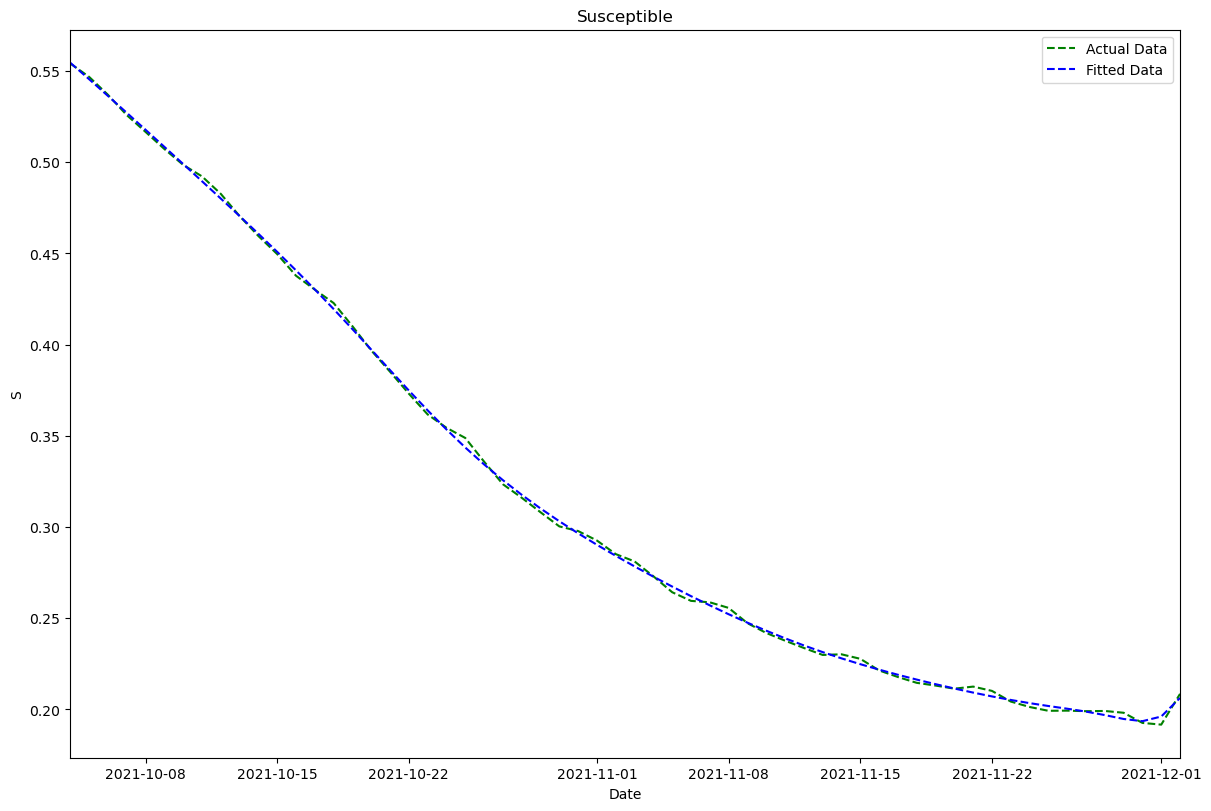

In [10]:
lims = (np.datetime64(st), np.datetime64(ed))

fig1, ax1 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax1.plot(dates,SS, '--g')
ax1.plot(dates,S_pred_m.flatten().tolist(), '--b')

ax1.set_xlabel('Date')
ax1.set_ylabel('S')
ax1.set_title('Susceptible')
ax1.set_xlim(lims)
#for label in ax1.get_xticklabels():
#    label.set_rotation(40)
#    label.set_horizontalalignment('right')
ax1.legend(['Actual Data',r'Fitted Data'])
# ax1[0].grid(axis='y')

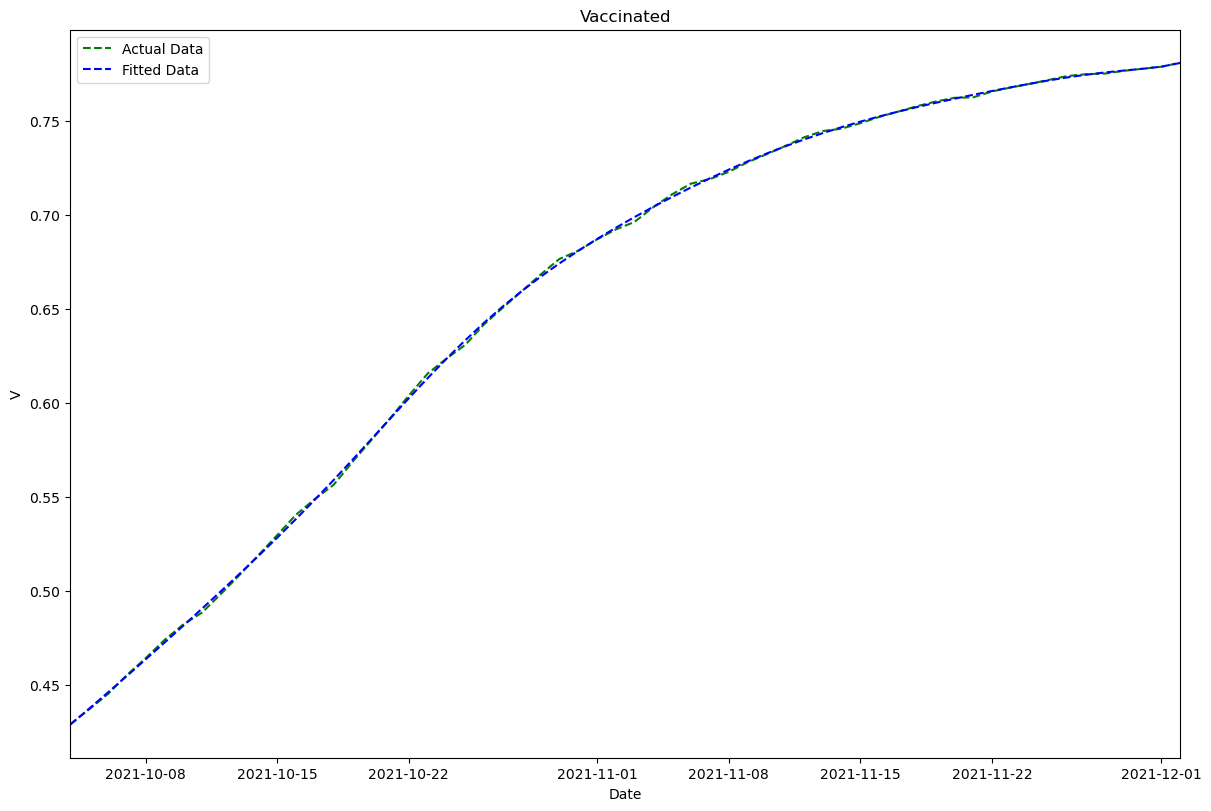

In [11]:
fig1, ax1 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax1.plot(dates,VV, '--g')
ax1.plot(dates,V_pred_m.flatten().tolist(), '--b')

ax1.set_xlabel('Date')
ax1.set_ylabel('V')
ax1.set_title('Vaccinated')
ax1.set_xlim(lims)
ax1.legend(['Actual Data',r'Fitted Data'])

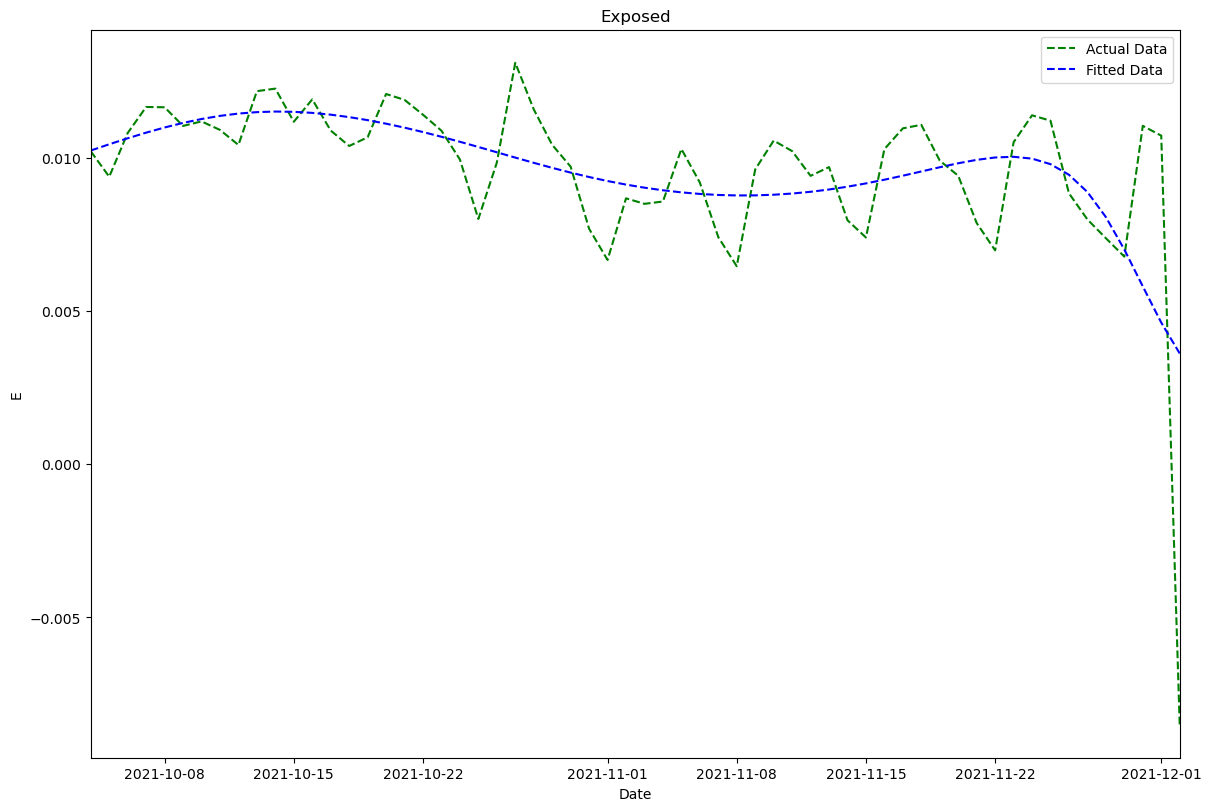

In [12]:
fig1, ax1 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax1.plot(dates,EE, '--g')
ax1.plot(dates,E_pred_m.flatten().tolist(), '--b')

ax1.set_xlabel('Date')
ax1.set_ylabel('E')
ax1.set_title('Exposed')
ax1.set_xlim(lims)
ax1.legend(['Actual Data',r'Fitted Data'])

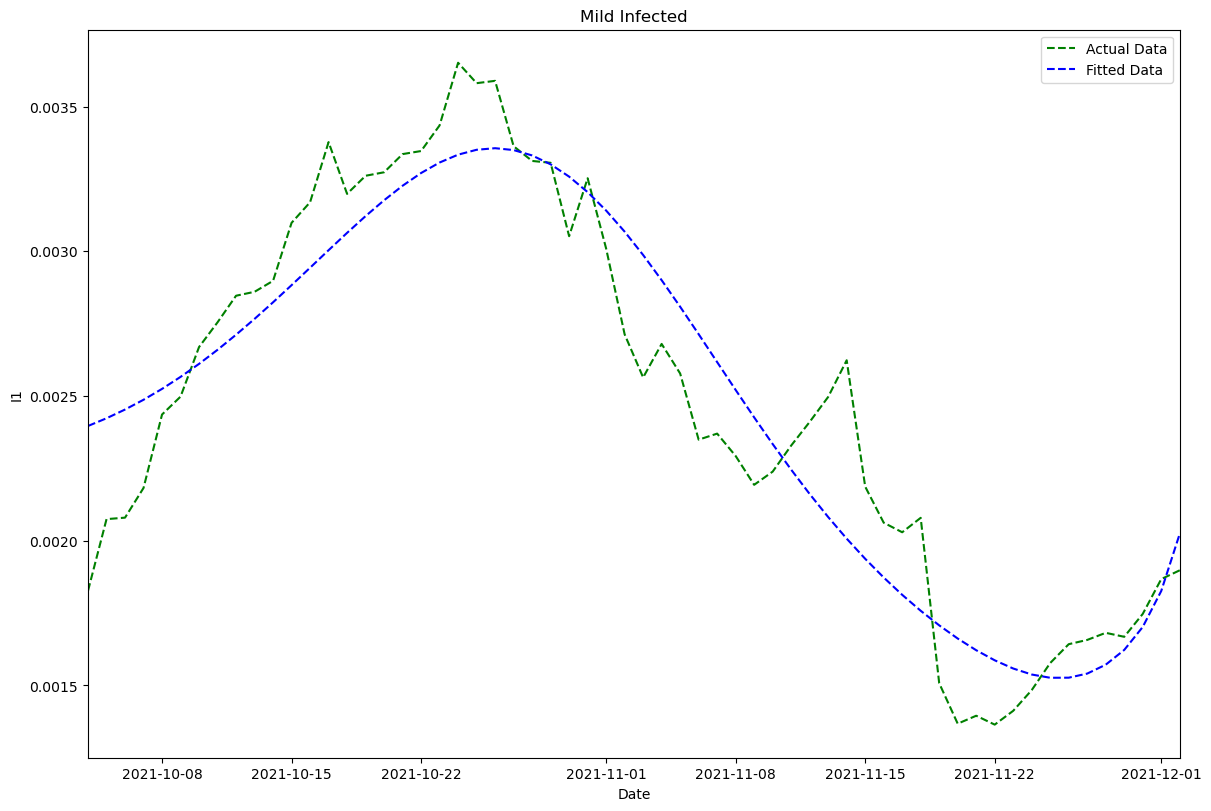

In [13]:
fig1, ax1 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax1.plot(dates,I1I, '--g')

ax1.plot(dates,I1_pred_m.flatten().tolist(), '--b')

ax1.set_xlabel('Date')
ax1.set_ylabel('I1')
ax1.set_title('Mild Infected')
ax1.set_xlim(lims)
ax1.legend(['Actual Data',r'Fitted Data'])

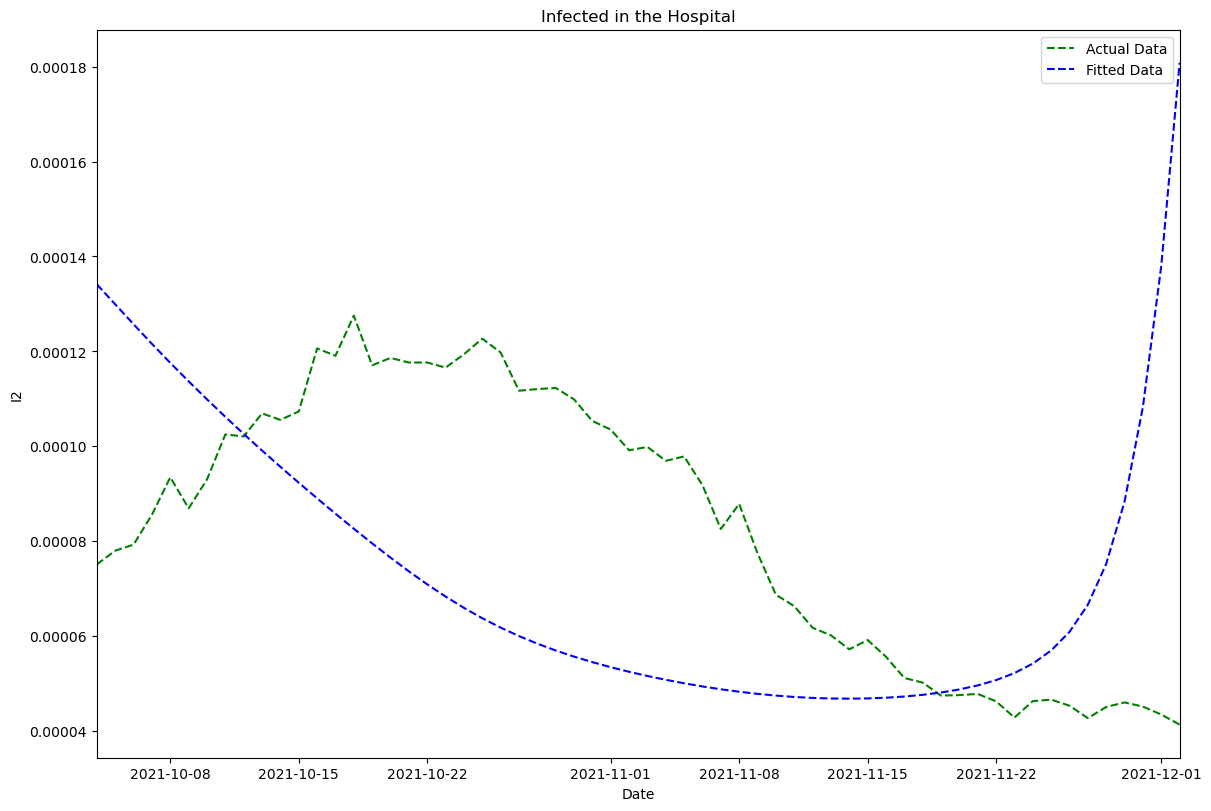

In [14]:
fig1, ax1 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax1.plot(dates,I2I, '--g')
ax1.plot(dates,I2_pred_m.flatten().tolist(), '--b')

ax1.set_xlabel('Date')
ax1.set_ylabel('I2')
ax1.set_title('Infected in the Hospital')
ax1.set_xlim(lims)
ax1.legend(['Actual Data',r'Fitted Data'])

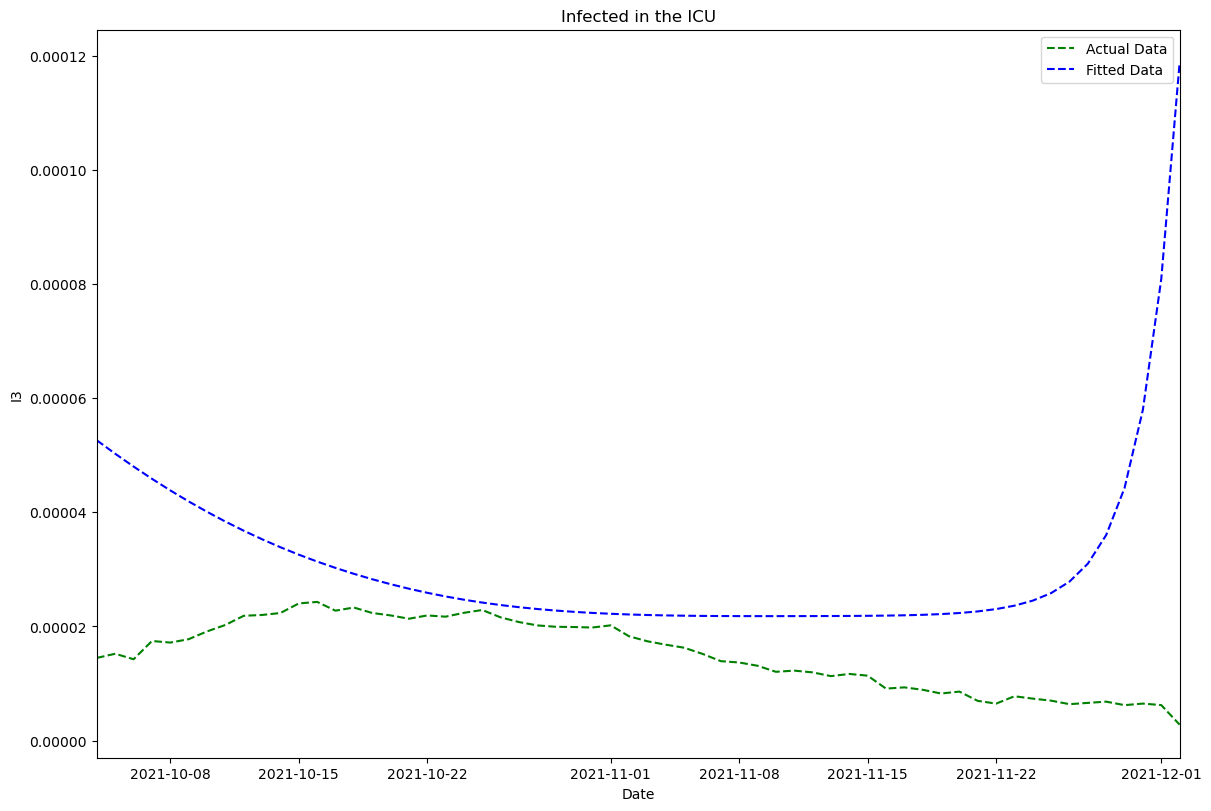

In [15]:
fig1, ax1 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax1.plot(dates,I3I, '--g')
ax1.plot(dates,I3_pred_m.flatten().tolist(), '--b')

ax1.set_xlabel('Date')
ax1.set_ylabel('I3')
ax1.set_title('Infected in the ICU')
ax1.set_xlim(lims)

ax1.legend(['Actual Data',r'Fitted Data'])

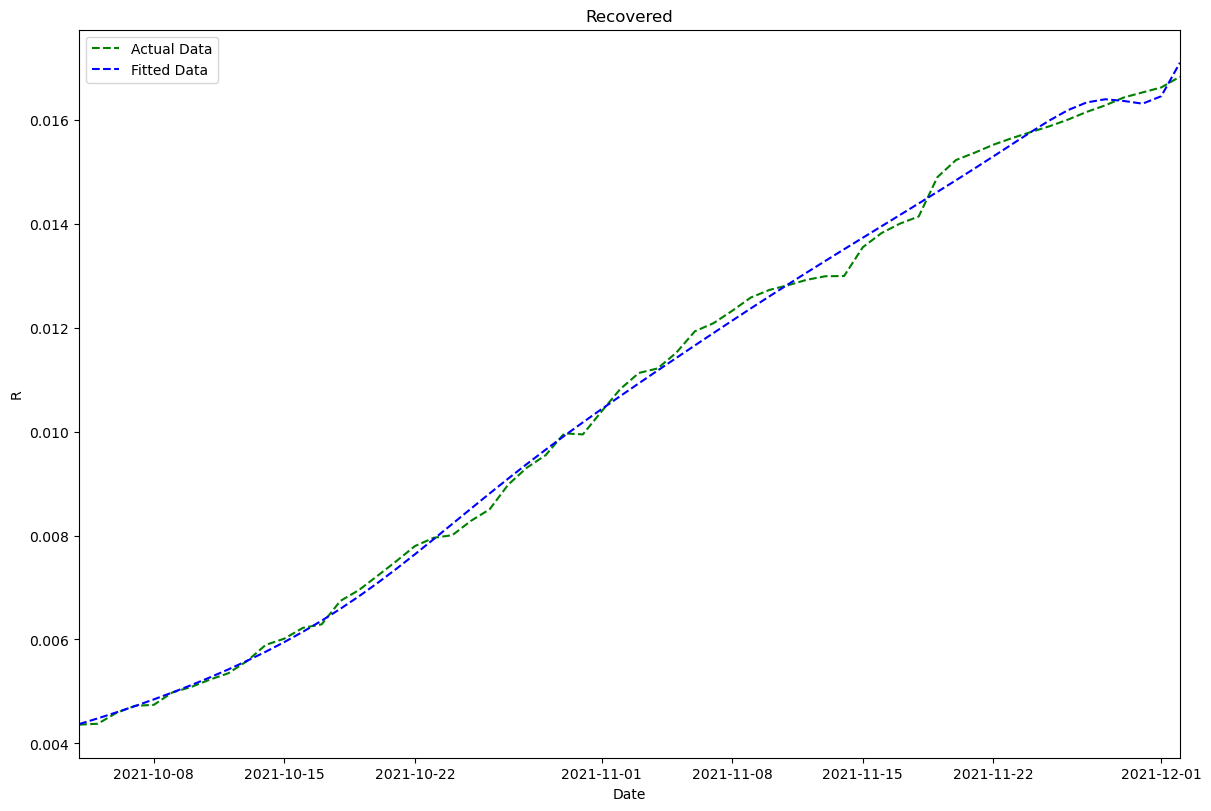

In [16]:
fig1, ax1 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax1.plot(dates,RR, '--g')
ax1.plot(dates,R_pred_m.flatten().tolist(), '--b')

ax1.set_xlabel('Date')
ax1.set_ylabel('R')
ax1.set_title('Recovered')
ax1.set_xlim(lims)
ax1.legend(['Actual Data',r'Fitted Data'])

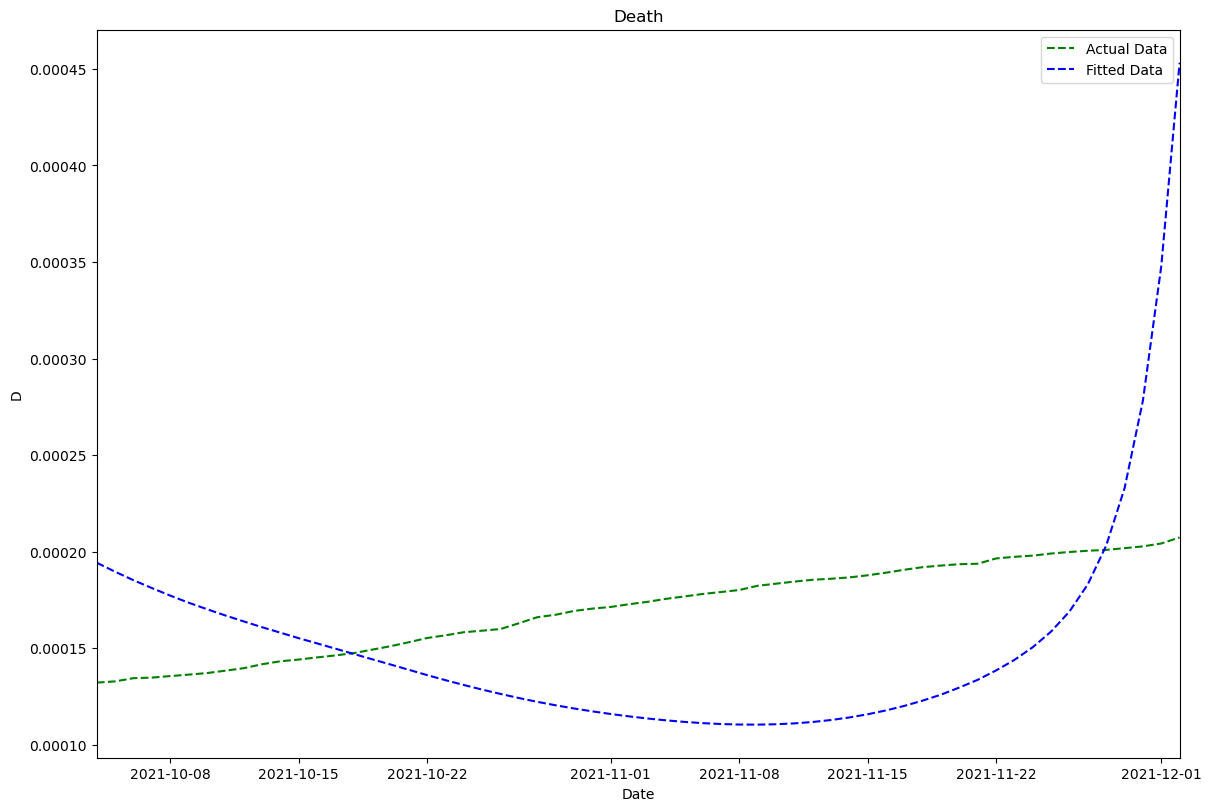

In [17]:
fig1, ax1 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax1.plot(dates,DD, '--g')
ax1.plot(dates,D_pred_m.flatten().tolist(), '--b')

ax1.set_xlabel('Date')
ax1.set_ylabel('D')
ax1.set_title('Death')
ax1.set_xlim(lims)
ax1.legend(['Actual Data',r'Fitted Data'])

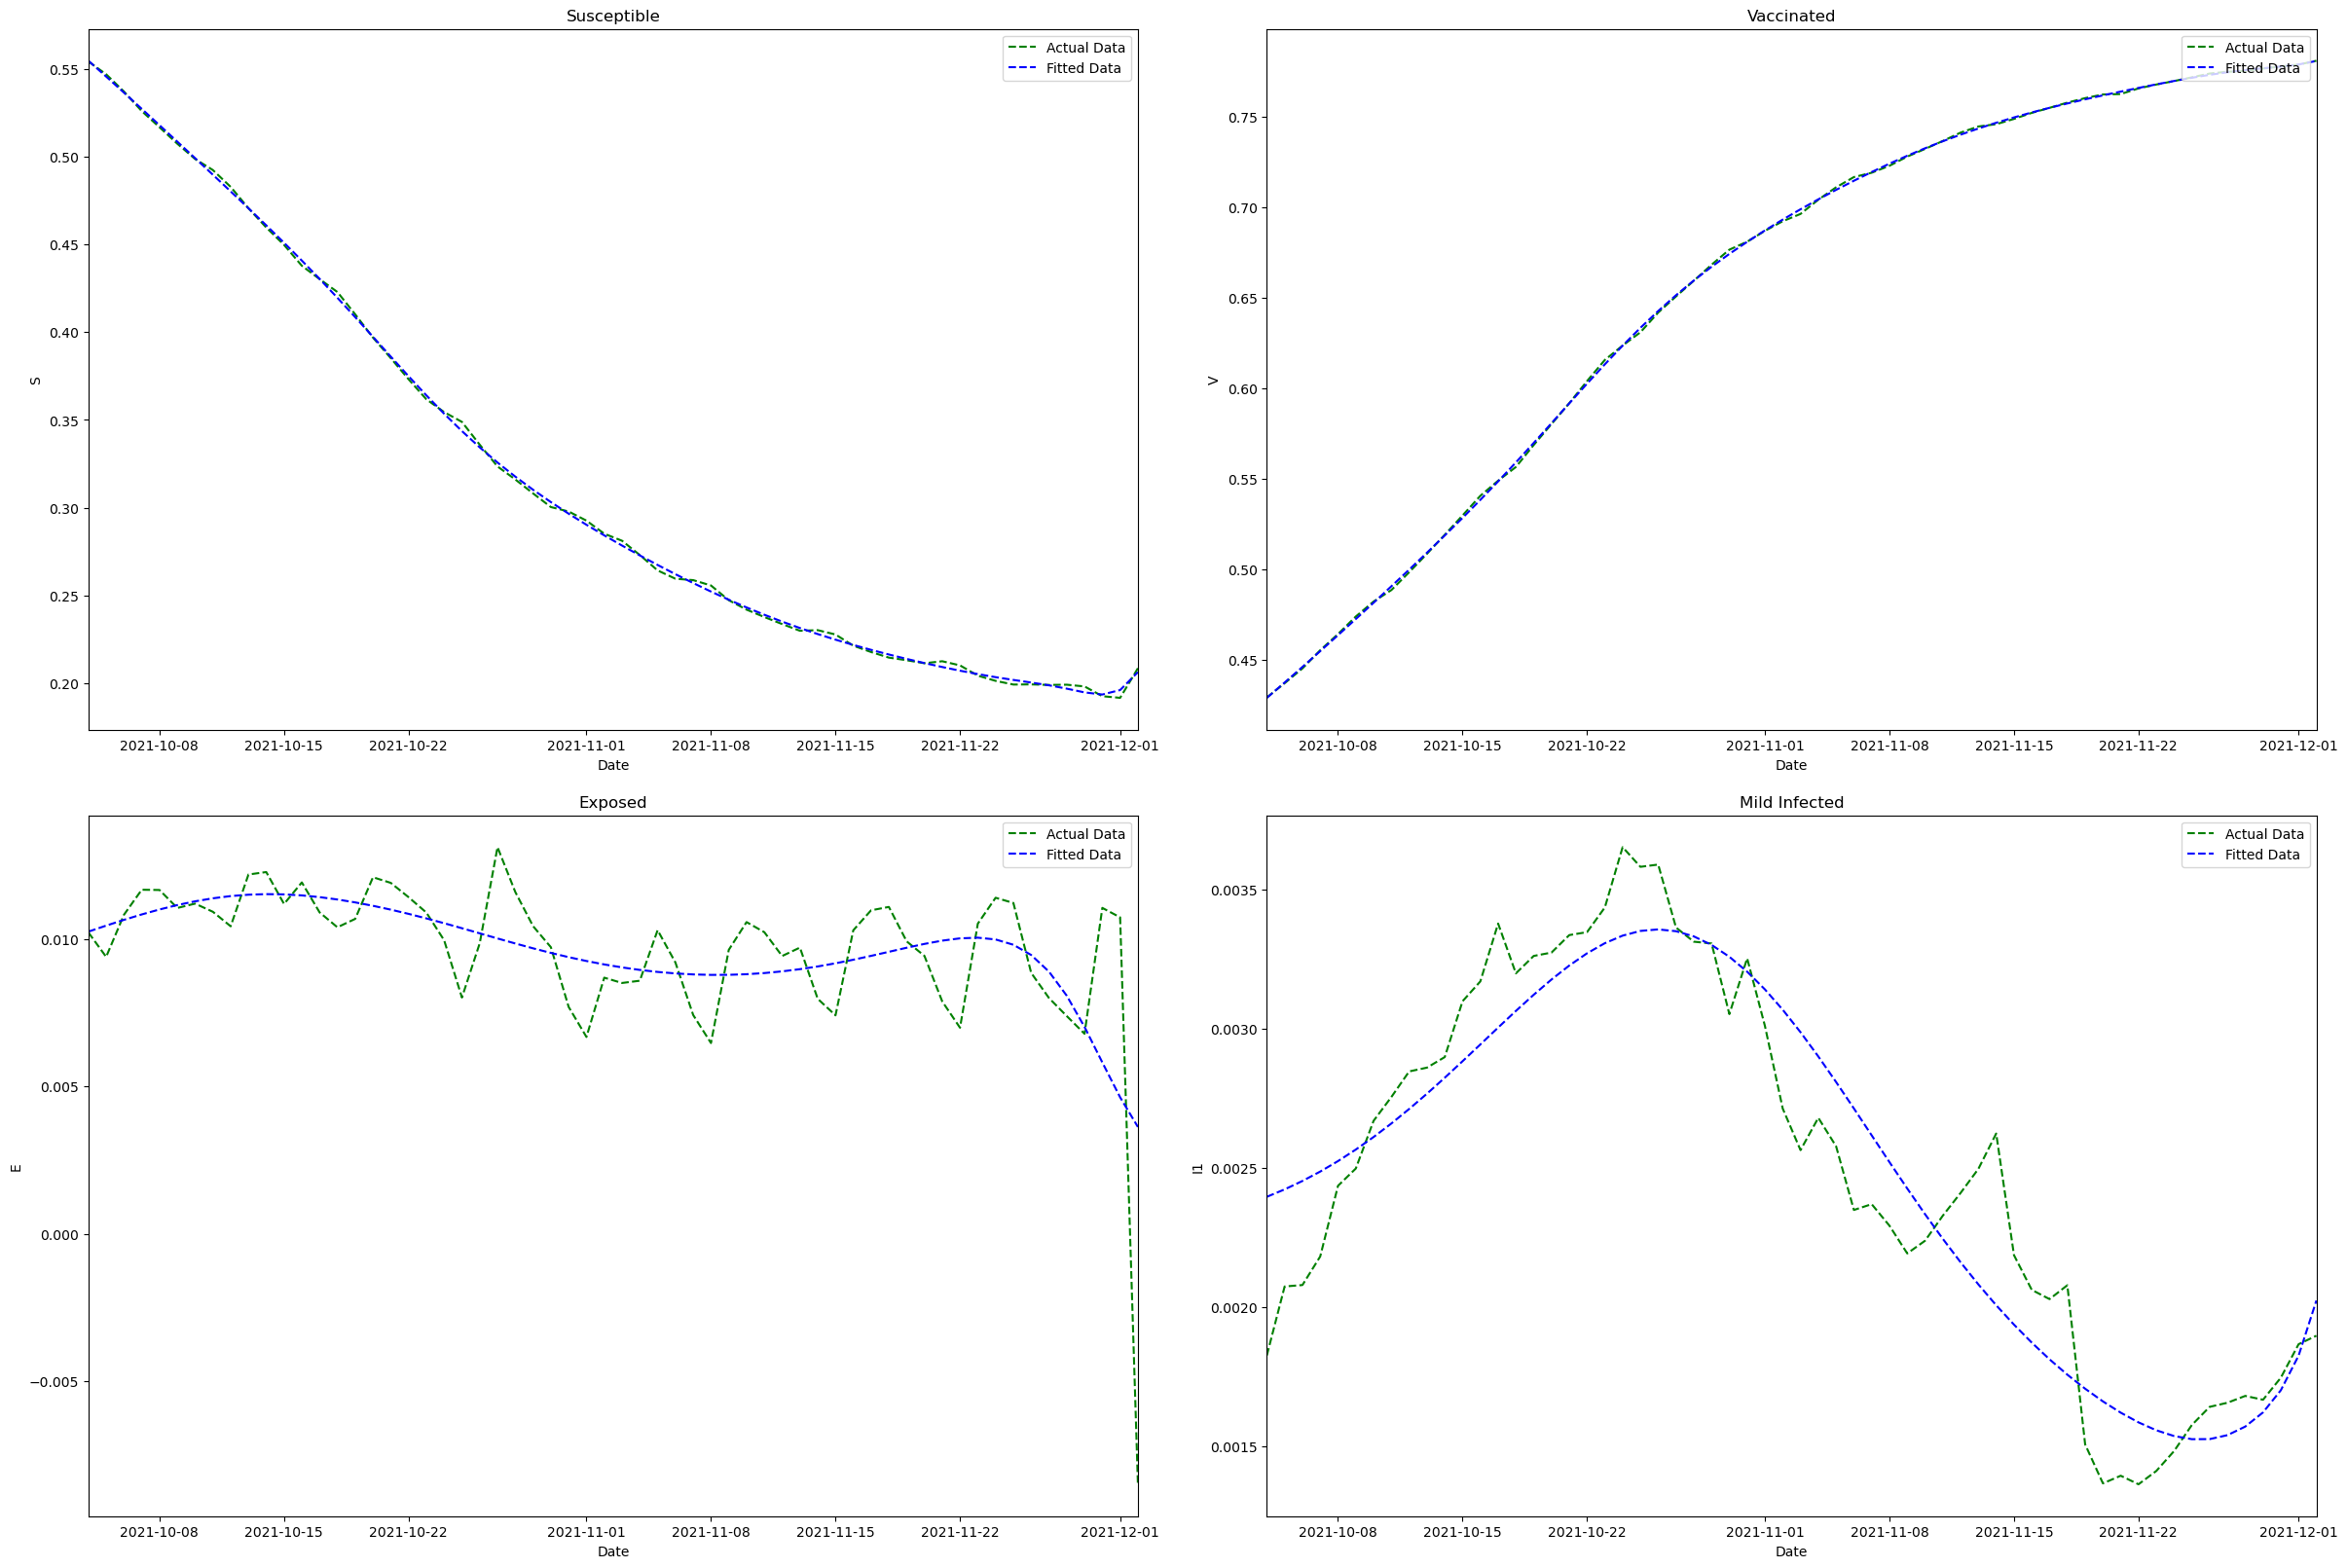

In [18]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(24, 16))

# Custom plots for each subplot
def plot_1(ax):
    ax.plot(dates,SS, '--g')
    ax.plot(dates,S_pred_m.flatten().tolist(), '--b')
    ax.set_xlabel('Date')
    ax.set_ylabel('S')
    ax.set_title('Susceptible')
    ax.set_xlim(lims)
    ax.legend(['Actual Data',r'Fitted Data'], loc='upper right')


def plot_2(ax):
    ax.plot(dates,VV, '--g')
    ax.plot(dates,V_pred_m.flatten().tolist(), '--b')
    ax.set_xlabel('Date')
    ax.set_ylabel('V')
    ax.set_title('Vaccinated')
    ax.set_xlim(lims)
    ax.legend(['Actual Data',r'Fitted Data'], loc='upper right')


def plot_3(ax):
    ax.plot(dates,EE, '--g')
    ax.plot(dates,E_pred_m.flatten().tolist(), '--b')
    ax.set_xlabel('Date')
    ax.set_ylabel('E')
    ax.set_title('Exposed')
    ax.set_xlim(lims)
    ax.legend(['Actual Data',r'Fitted Data'], loc='upper right')


def plot_4(ax):
    ax.plot(dates,I1I, '--g')
    ax.plot(dates,I1_pred_m.flatten().tolist(), '--b')
    ax.set_xlabel('Date')
    ax.set_ylabel('I1')
    ax.set_title('Mild Infected')
    ax.set_xlim(lims)
    ax.legend(['Actual Data',r'Fitted Data'], loc='upper right')


# Apply different plots to each subplot
plot_1(axs[0, 0])
plot_2(axs[0, 1])
plot_3(axs[1, 0])
plot_4(axs[1, 1])

# Set common labels 
for ax in axs.flat:
    ax.set_xlabel('Date')

# Display the plot
#plt.show()
plt.savefig('sto_train_data_fitting_'+str(POINTS)+'xpoints_'+str(GRID)+'0%grid_seed'+str(SEED)+'.png')

In [19]:
print('TOTAL_RMSE', total_rmse)
print('TOTAL_MAPE', total_mape)

TOTAL_RMSE 0.005898294194922318
TOTAL_MAPE 2.6629521525959348


alpha_cal = 0.00135
sigma_cal = 0.06334
beta1_cal = 0.30156
beta2_cal = 0.163
beta3_cal = 0.04293
delta1_cal = 0.29342
delta2_cal = 0.2821
delta3_cal = 0.14151
gamma_cal = 0.26671
p1_cal = 0.01845
p2_cal = 0.14304
mu_cal = 0.0014
sigma1_cal = 0.0916
sigma2_cal = 0.06924
sigma3_cal = 0.105
sigma4_cal = 0.05854
sigma5_cal = 0.07896
sigma6_cal = 0.06242
sigma7_cal = 0.05814
sigma8_cal = 0.06212


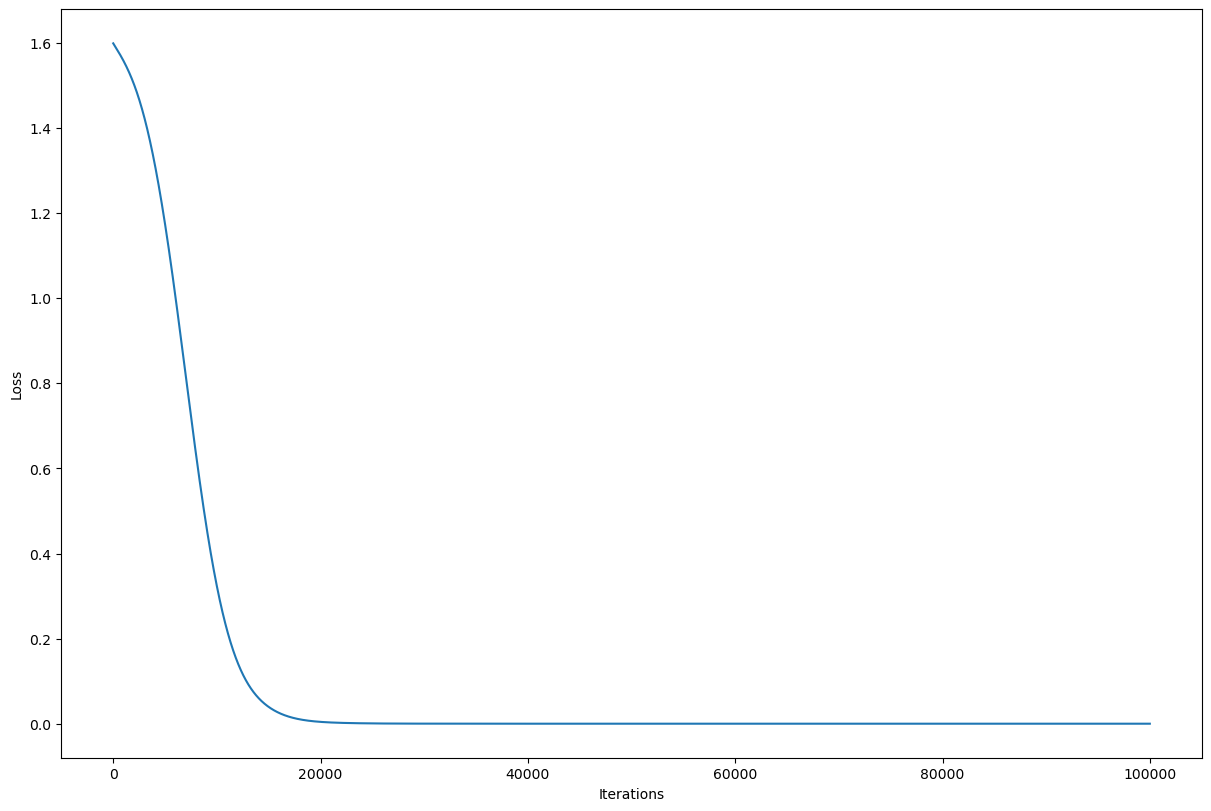

In [20]:
print('alpha_cal =', alpha)
print('sigma_cal =',sigma) 
print('beta1_cal =',beta1) 
print('beta2_cal =',beta2)
print('beta3_cal =',beta3)
print('delta1_cal =',delta1)
print('delta2_cal =',delta2)
print('delta3_cal =',delta3)
print('gamma_cal =',gamma)
print('p1_cal =',p1)
print('p2_cal =',p2)
print('mu_cal =',mu)
print('sigma1_cal =',sigma1) 
print('sigma2_cal =',sigma2)
print('sigma3_cal =',sigma3)
print('sigma4_cal =',sigma4)
print('sigma5_cal =',sigma5)
print('sigma6_cal =',sigma6)
print('sigma7_cal =',sigma7)
print('sigma8_cal =',sigma8)

fig2, ax2 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax2.plot(total_loss)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Loss')
plt.savefig('sto_train_loss_'+str(POINTS)+'xpoints_'+str(GRID)+'0%grid_seed'+str(SEED)+'.png')